<a id="0"></a>
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">INTRODUCTION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">In this notebook we will create folds which we will use later while training our model.
<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. READ DATASETS](#2)

* [3. CREATE FOLDS](#3)
   * [3.1 KFold](#3.1)
   * [3.2 STRATIFIED-KFold](#3.2)
    
    
* [4. SAVE FOLDS](#4)
    
* [5. CONCLUSION](#5)
    
* [6. END](#6)

<a id="1"></a>
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">IMPORTING LIBRARIES</p>

In [1]:
import numpy as np
import pandas as pd 
import warnings
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")
%matplotlib inline
import gc

import time
import warnings
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd 

import os
import gc
import psutil

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score,f1_score

from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures

from optuna.integration import LightGBMPruningCallback

# get skewed features to impute median instead of mean
from scipy.stats import skew
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBRegressor, XGBRFRegressor

import itertools
import optuna
from lightgbm import LGBMClassifier,LGBMRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold,StratifiedKFold

<a id="1"></a>
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>

In [2]:
#sample = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")
train  = pd.read_csv("../input/liver-disease-competition/train_dataset.csv")
test = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")

In [3]:
train.drop('Cholesterol',axis=1,inplace=True)  # because almost 44% nan value
test.drop('Cholesterol',axis=1,inplace=True)

train.drop('Tryglicerides',axis=1,inplace=True)  # because almost 40% nan value
test.drop('Tryglicerides',axis=1,inplace=True)

all_features = list(test.columns)[1:]

df = pd.concat([train[all_features], test[all_features]], axis=0)
dobj = df.select_dtypes(['object'])
obj_cols= dobj.columns

train[obj_cols]= train[obj_cols].fillna(value=train[obj_cols].mode().iloc[0,:])
test[obj_cols]= test[obj_cols].fillna(value=test[obj_cols].mode().iloc[0,:])

dobj = df.select_dtypes(exclude=['object'])
int_cols = dobj.columns

int_cols1 = ['Albumin','Platelets']
int_cols2 = list(set(int_cols)- set(int_cols1))

train[int_cols1]= train[int_cols1].fillna(value=train[int_cols1].mean())
train[int_cols2]= train[int_cols2].fillna(value=train[int_cols2].mode().iloc[0,:])

test[int_cols1]= test[int_cols1].fillna(value=test[int_cols1].mean())
test[int_cols2]= test[int_cols2].fillna(value=test[int_cols2].mode().iloc[0,:])

train['Bilirubin_modified'] = train['Bilirubin'] * 88.4
test['Bilirubin_modified'] = test['Bilirubin'] * 88.4

train['normal_Bilirubin'] = ((train.Bilirubin_modified <= 20) & (1 <= train.Bilirubin_modified)).astype(int)
test['normal_Bilirubin'] = ((test.Bilirubin_modified <= 20) & (1 <= test.Bilirubin_modified)).astype(int)

train['Albumin_modified'] = train['Albumin']* 10
test['Albumin_modified'] = test['Albumin']* 10

train['normal_Albumin'] = ((train.Albumin_modified <= 44) &  (train.Albumin_modified >= 32)).astype(int)
test['normal_Albumin'] = ((test.Albumin_modified <= 44) &  (test.Albumin_modified >= 32)).astype(int)

train['normal_Alk_Phos']  =  ((train['Alk_Phos'] <= 140 ) & (train['Alk_Phos'] >= 35 )).astype(int)
test['normal_Alk_Phos']  =  ((test['Alk_Phos'] <= 140 ) & (test['Alk_Phos'] >= 35 )).astype(int)

train['SGOT_modified'] = train['SGOT']* 1000
test['SGOT_modified'] = test['SGOT']* 1000

train['normal_SGOT']  =  ((train['SGOT_modified'] <= 30 ) & (train['SGOT_modified'] >= 5 )).astype(int)
test['normal_SGOT']  =  ((test['SGOT_modified'] <= 30 ) & (test['SGOT_modified'] >= 5 )).astype(int)

# Let's drop duplicates
duplicate_cols = ['Bilirubin','Albumin','SGOT'] # we didn't create Alk_Phos_modified
test.drop(duplicate_cols, axis=1,inplace=True)
train.drop(duplicate_cols, axis=1,inplace=True)

useful_cols = test.drop("ID",axis=1).columns

t = test.select_dtypes(['object'])
obj_cols = t.columns

train['isTrain'] = 1
test['isTrain'] = 0

df = pd.concat([train,test])

df['Age_bins']= pd.cut(df.Age.astype(int), 5)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label = LabelEncoder()
df['Age_bins']=label.fit_transform(df['Age_bins'])

df= pd.get_dummies(data= df,columns=obj_cols,drop_first= True)

train = df[df.isTrain == 1]
test = df[df.isTrain == 0]

train.drop('isTrain', axis= 1,inplace=True)
test.drop(['isTrain','Stage'], axis=1, inplace=True)
useful_features = test.drop('ID',axis=1).columns.tolist()

In [4]:
train_data = train.copy()
test_data = test.copy()

In [5]:
display(train.shape, test_data.shape, len(useful_features))
print()
print(useful_features)

(6800, 25)

(3200, 24)

23


['N_Days', 'Age', 'Copper', 'Alk_Phos', 'Platelets', 'Prothrombin', 'Bilirubin_modified', 'normal_Bilirubin', 'Albumin_modified', 'normal_Albumin', 'normal_Alk_Phos', 'SGOT_modified', 'normal_SGOT', 'Age_bins', 'Status_CL', 'Status_D', 'Drug_Placebo', 'Sex_M', 'Ascites_Y', 'Hepatomegaly_Y', 'Spiders_Y', 'Edema_S', 'Edema_Y']


In [6]:
train_data.head(2)

,ID,N_Days,Age,Copper,Alk_Phos,Platelets,Prothrombin,Stage,Bilirubin_modified,normal_Bilirubin,...,Age_bins,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,7135,1654,19581,84.0,1500.8,293.0,10.2,4.0,26.52,0,...,2,1,0,0,0,0,0,1,0,0
1,7326,41,22880,4.0,1835.4,308.0,10.8,1.0,26.52,0,...,3,0,0,0,0,0,0,0,0,0


In [7]:
test_data.head(2)

,ID,N_Days,Age,Copper,Alk_Phos,Platelets,Prothrombin,Bilirubin_modified,normal_Bilirubin,Albumin_modified,...,Age_bins,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,3870,41,22553,4.0,289.0,169.0,11.6,123.76,0,36.2,...,3,0,0,1,0,0,0,0,0,0
1,3462,1811,16223,92.0,1748.1,321.0,11.5,26.52,0,28.0,...,1,0,0,0,0,0,1,0,0,0


In [8]:
train_data.shape, test_data.shape

((6800, 25), (3200, 24))

<a id="3"></a>
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">CREATE FOLDS</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">There are many ways to create folds. 
<br> 1.You can either create folds from before hand by creating a new columns of folds and use it everywhere to make your validation predictions and OOF predictions. or,
<br> 2. You can call each time KFold or Stratified KFold and make the splits while training a model.
<br> If these things are not clear don't worry we will cover these things in orderly way.<br>
I will be following method one, but there is no much difference between the two methods only difference is in the time of making split.
<br>
Note:- Just that in case1 you don't have to care about splits everytime, while in case2 you have to make exactly same split each time you train a model i.e. you have to use same random state while splitting.
<br>
    <b> Let's first see how target label is distributed </b></p>

In [9]:
train_data['Stage'].value_counts()

4.0    3506
2.0    1507
3.0    1322
1.0     465
Name: Stage, dtype: int64

<p style="font-family:newtimeroman;font-size:120%;color:#444160;">We see it is unbalanced class i.e. no of data points in class survived and no of data points in class not survived are not same. So we can't just use KFold split, we have to use stratified KFold split. This is because Stratified KFold ensures that each fold has same proportion of classes. In case of Balanced class we don't have to worry about this and can use KFold there. 
<br>
Hence Stratified KFold is an improved version of KFold split so be it balance or unbalance class it is advised to use Stratified KFold.
<br> To show what I am saying we will do both KFold split as well as Stratified KFold split.</p>
<a id="3.1"></a>
<p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">KFOLD</p>


In [10]:
kf = KFold(n_splits=10, shuffle=True, random_state=21) # we will create 10 folds since dataset is not that large, if we had huge dataset we could have made 10 folds. 

In [11]:
for fold, (train_indices, valid_indices) in enumerate(kf.split(train_data)):
    train_data.loc[valid_indices,'fold'] = fold # this randomly assigns one of the values [0,1,2,3,4] to each row :- Thus it divides training set in 5 parts

In [12]:
train_data.head(2) # fold column contains float type

,ID,N_Days,Age,Copper,Alk_Phos,Platelets,Prothrombin,Stage,Bilirubin_modified,normal_Bilirubin,...,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y,fold
0,7135,1654,19581,84.0,1500.8,293.0,10.2,4.0,26.52,0,...,1,0,0,0,0,0,1,0,0,0.0
1,7326,41,22880,4.0,1835.4,308.0,10.8,1.0,26.52,0,...,0,0,0,0,0,0,0,0,0,2.0


In [13]:
train_data.fold = train_data.fold.astype(int) # convert fold column to int type

In [14]:
train_data.head(2)

,ID,N_Days,Age,Copper,Alk_Phos,Platelets,Prothrombin,Stage,Bilirubin_modified,normal_Bilirubin,...,Status_CL,Status_D,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y,fold
0,7135,1654,19581,84.0,1500.8,293.0,10.2,4.0,26.52,0,...,1,0,0,0,0,0,1,0,0,0
1,7326,41,22880,4.0,1835.4,308.0,10.8,1.0,26.52,0,...,0,0,0,0,0,0,0,0,0,2


In [15]:
set(train_data.Stage)

{1.0, 2.0, 3.0, 4.0}

In [16]:
for i in range(10):  
    t = train_data.loc[train_data['fold']==i,'Stage'].value_counts()
    t=(t/t.sum()).tolist()
    print(f"For fold {i} class ratio is: {t[0],t[1],t[2],t[3]}")  # we now see each class has same proportions

For fold 0 class ratio is: (0.5441176470588235, 0.2, 0.19264705882352942, 0.06323529411764706)
For fold 1 class ratio is: (0.5205882352941177, 0.21176470588235294, 0.20147058823529412, 0.0661764705882353)
For fold 2 class ratio is: (0.5205882352941177, 0.21764705882352942, 0.19117647058823528, 0.07058823529411765)
For fold 3 class ratio is: (0.5470588235294118, 0.20441176470588235, 0.17794117647058824, 0.07058823529411765)
For fold 4 class ratio is: (0.5029411764705882, 0.23823529411764705, 0.20147058823529412, 0.057352941176470586)
For fold 5 class ratio is: (0.4970588235294118, 0.22941176470588234, 0.19558823529411765, 0.07794117647058824)
For fold 6 class ratio is: (0.5220588235294118, 0.22205882352941175, 0.19411764705882353, 0.061764705882352944)
For fold 7 class ratio is: (0.4823529411764706, 0.2323529411764706, 0.2088235294117647, 0.07647058823529412)
For fold 8 class ratio is: (0.5029411764705882, 0.24411764705882352, 0.18529411764705883, 0.06764705882352941)
For fold 9 class r

<p style="font-family:newtimeroman;font-size:120%;color:#444160;">We see ratio of classes in each fold are quite varying, this may make our model overfit. So next we will do Stratified KFold and see the difference.</p>
<a id="3.2"></a>
<p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">STRATIFIED-KFOLD</p>

In [17]:
import os
import random
import tensorflow as tf
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    #torch.manual_seed(seed)
seed_everything(17)
print(np.random.randint(3,10)) # it should return 4

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

4


In [18]:
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_data,train_data.Stage)):
    #print(fold)
    train_data.loc[valid_indices,'fold'] = fold
train_data.fold = train_data.fold.astype(int) # convert fold column to int types


In [19]:
for i in range(10):  
    t = train_data.loc[train_data['fold']==i,'Stage'].value_counts()
    t=(t/t.sum()).tolist()
    print(f"For fold {i} class ratio is: {t[0],t[1],t[2],t[3]}")  # we now see each class has same proportions

For fold 0 class ratio is: (0.5161764705882353, 0.22058823529411764, 0.19411764705882353, 0.06911764705882353)
For fold 1 class ratio is: (0.5161764705882353, 0.22058823529411764, 0.19558823529411765, 0.06764705882352941)
For fold 2 class ratio is: (0.5161764705882353, 0.22058823529411764, 0.19558823529411765, 0.06764705882352941)
For fold 3 class ratio is: (0.5161764705882353, 0.22205882352941175, 0.19411764705882353, 0.06764705882352941)
For fold 4 class ratio is: (0.5161764705882353, 0.22205882352941175, 0.19411764705882353, 0.06764705882352941)
For fold 5 class ratio is: (0.5161764705882353, 0.22205882352941175, 0.19411764705882353, 0.06764705882352941)
For fold 6 class ratio is: (0.5147058823529411, 0.22205882352941175, 0.19411764705882353, 0.06911764705882353)
For fold 7 class ratio is: (0.5147058823529411, 0.22205882352941175, 0.19411764705882353, 0.06911764705882353)
For fold 8 class ratio is: (0.5147058823529411, 0.22205882352941175, 0.19411764705882353, 0.06911764705882353)
F

<p style="font-family:newtimeroman;font-size:120%;color:#444160;">Now the ratio of labels in each fold are quite stable as expected.</p>

In [20]:
train_data.to_csv('LD_Folds.csv',index=False)

<p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">Important features</p>

In [21]:
useful_featurs = test_data.drop('ID',axis=1).columns.tolist()
my_folds = train_data.copy()
test = test_data.copy()
len(useful_features)

23

In [22]:
# meta data
comp_name = 'liver_disease'
target_name = 'Stage'
id_name = 'ID'

In [23]:
scores =[]
for fold in range(10):
    xtrain = my_folds[my_folds.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds.fold == fold].reset_index(drop=True)
    xtest = test[useful_features].copy()
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)

    # scale
    ss = MinMaxScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)

#     xtrain = pd.DataFrame(xtrain, columns=useful_features)
#     xvalid = pd.DataFrame(xvalid, columns=useful_features)
#     xtest = pd.DataFrame(xtest, columns=useful_features)
    
    
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])
        
    model = LGBMClassifier(objective="multiclass",random_state=211 ) #, device_type='gpu')
    model.fit(xtrain, ytrain,
            eval_set=[(xvalid, yvalid)],
            eval_metric="auc_mu",
            early_stopping_rounds=500,
            verbose=0
     )
    valid_preds = model.predict(xvalid)
    test_preds = model.predict(xtest)
    
    c = [None, 'micro', 'macro', 'weighted']
    # 0.1737115463043224 0.29110373277445856
    # 0.5113235294117647 0.007893374647246869
    # 0.1737115463043224 0.006992213763111059
    # 0.35301949303162244 0.004824478179229641
    score= f1_score(yvalid, valid_preds,average= c[1] )
    #score = accuracy_score(yvalid, valid_preds)
    scores.append(score)
    
print("score:- ")
print(scores)
print("score mean and std:- ")
print(np.mean(scores), np.std(scores))

score:- 
[0.5088235294117647, 0.5161764705882353, 0.5161764705882353, 0.5161764705882353, 0.5161764705882353, 0.5161764705882353, 0.49117647058823527, 0.5147058823529411, 0.5147058823529411, 0.5029411764705882]
score mean and std:- 
0.5113235294117647 0.007893374647246869


In [24]:
model.feature_importances_, len(model.feature_importances_) # this is equal to useful features

(array([752, 765, 617, 656, 834, 617, 590,   0, 922,   2,   0, 546,   0,
         10,  22, 103,  70,  35,  33,  63,  33,  38,  12], dtype=int32),
 23)

In [25]:
T=list(zip(model.feature_importances_,useful_features))
T=sorted(T,key=lambda x: x[0], reverse=True)#[:-10]
T

[(922, 'Albumin_modified'),
 (834, 'Platelets'),
 (765, 'Age'),
 (752, 'N_Days'),
 (656, 'Alk_Phos'),
 (617, 'Copper'),
 (617, 'Prothrombin'),
 (590, 'Bilirubin_modified'),
 (546, 'SGOT_modified'),
 (103, 'Status_D'),
 (70, 'Drug_Placebo'),
 (63, 'Hepatomegaly_Y'),
 (38, 'Edema_S'),
 (35, 'Sex_M'),
 (33, 'Ascites_Y'),
 (33, 'Spiders_Y'),
 (22, 'Status_CL'),
 (12, 'Edema_Y'),
 (10, 'Age_bins'),
 (2, 'normal_Albumin'),
 (0, 'normal_Bilirubin'),
 (0, 'normal_Alk_Phos'),
 (0, 'normal_SGOT')]

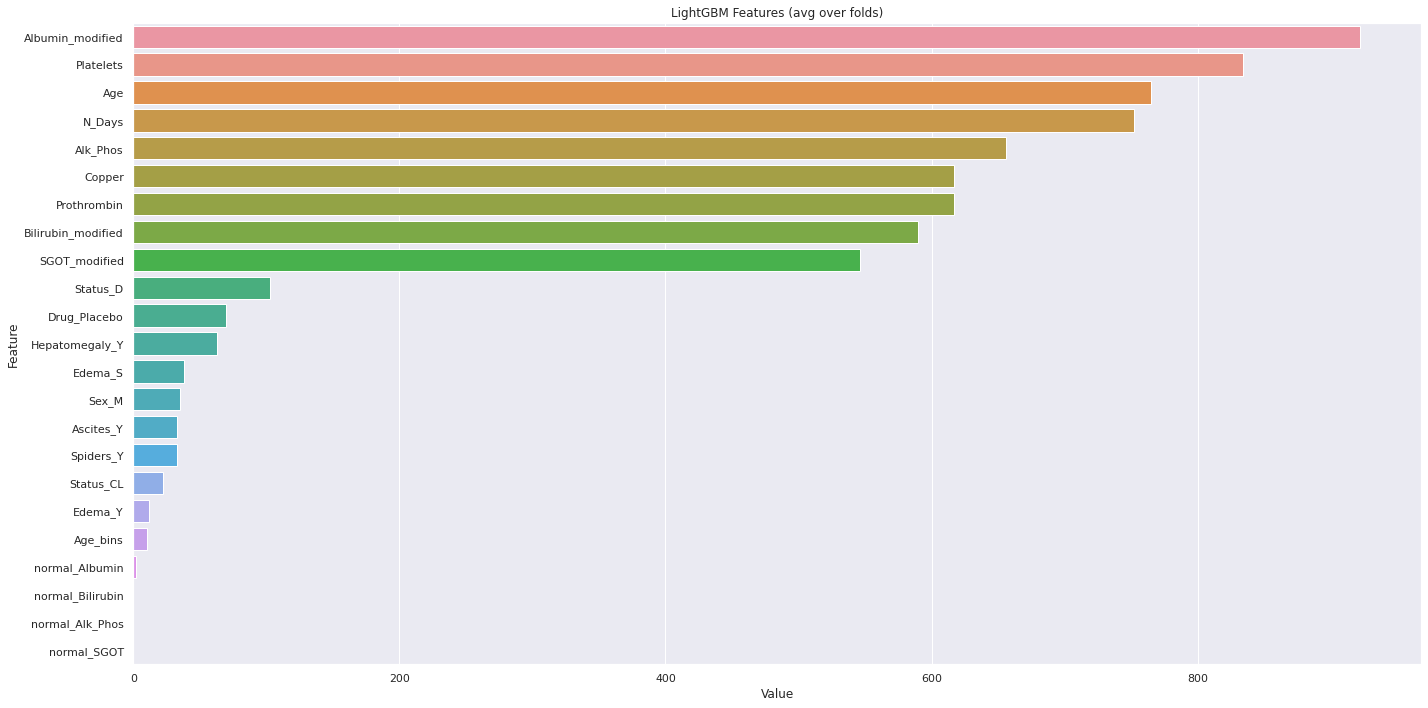

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(T, columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [27]:
filtered_features= [i[1] for i in T[:-4]]  
print(filtered_features)

['Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']


## We will now do all these steps at once:-

In [28]:
#sample = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")
train  = pd.read_csv("../input/liver-disease-competition/train_dataset.csv")
test = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")

In [29]:
# meta data
comp_name = 'liver_disease'
target_name = 'Stage'
id_name = 'ID'

In [30]:
train.drop('Cholesterol',axis=1,inplace=True)  # because almost 44% nan value
test.drop('Cholesterol',axis=1,inplace=True)

train.drop('Tryglicerides',axis=1,inplace=True)  # because almost 40% nan value
test.drop('Tryglicerides',axis=1,inplace=True)

all_features = list(test.columns)[1:]

df = pd.concat([train[all_features], test[all_features]], axis=0)
dobj = df.select_dtypes(['object'])
obj_cols= dobj.columns

train[obj_cols]= train[obj_cols].fillna(value=train[obj_cols].mode().iloc[0,:])
test[obj_cols]= test[obj_cols].fillna(value=test[obj_cols].mode().iloc[0,:])

dobj = df.select_dtypes(exclude=['object'])
int_cols = dobj.columns

int_cols1 = ['Albumin','Platelets']
int_cols2 = list(set(int_cols)- set(int_cols1))

train[int_cols1]= train[int_cols1].fillna(value=train[int_cols1].mean())
train[int_cols2]= train[int_cols2].fillna(value=train[int_cols2].mode().iloc[0,:])

test[int_cols1]= test[int_cols1].fillna(value=test[int_cols1].mean())
test[int_cols2]= test[int_cols2].fillna(value=test[int_cols2].mode().iloc[0,:])

train['Bilirubin_modified'] = train['Bilirubin'] * 88.4
test['Bilirubin_modified'] = test['Bilirubin'] * 88.4

train['normal_Bilirubin'] = ((train.Bilirubin_modified <= 20) & (1 <= train.Bilirubin_modified)).astype(int)
test['normal_Bilirubin'] = ((test.Bilirubin_modified <= 20) & (1 <= test.Bilirubin_modified)).astype(int)

train['Albumin_modified'] = train['Albumin']* 10
test['Albumin_modified'] = test['Albumin']* 10

train['normal_Albumin'] = ((train.Albumin_modified <= 44) &  (train.Albumin_modified >= 32)).astype(int)
test['normal_Albumin'] = ((test.Albumin_modified <= 44) &  (test.Albumin_modified >= 32)).astype(int)

train['normal_Alk_Phos']  =  ((train['Alk_Phos'] <= 140 ) & (train['Alk_Phos'] >= 35 )).astype(int)
test['normal_Alk_Phos']  =  ((test['Alk_Phos'] <= 140 ) & (test['Alk_Phos'] >= 35 )).astype(int)

train['SGOT_modified'] = train['SGOT']* 1000
test['SGOT_modified'] = test['SGOT']* 1000

train['normal_SGOT']  =  ((train['SGOT_modified'] <= 30 ) & (train['SGOT_modified'] >= 5 )).astype(int)
test['normal_SGOT']  =  ((test['SGOT_modified'] <= 30 ) & (test['SGOT_modified'] >= 5 )).astype(int)

# Let's drop duplicates
duplicate_cols = ['Bilirubin','Albumin','SGOT'] # we didn't create Alk_Phos_modified
test.drop(duplicate_cols, axis=1,inplace=True)
train.drop(duplicate_cols, axis=1,inplace=True)

useful_cols = test.drop("ID",axis=1).columns

t = test.select_dtypes(['object'])
obj_cols = t.columns

train['isTrain'] = 1
test['isTrain'] = 0

df = pd.concat([train,test])

df['Age_bins']= pd.cut(df.Age.astype(int), 5)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label = LabelEncoder()
df['Age_bins']=label.fit_transform(df['Age_bins'])

df= pd.get_dummies(data= df,columns=obj_cols,drop_first= True)

train = df[df.isTrain == 1]
test = df[df.isTrain == 0]

train.drop('isTrain', axis= 1,inplace=True)
test.drop(['isTrain','Stage'], axis=1, inplace=True)
useful_features = test.drop('ID',axis=1).columns.tolist()

my_folds = train.copy()
my_folds['Stage'].value_counts()  # we see it is unbalanced so we will use Stratified kfold
#------------------------------ do it together to maintain same split
import os
import random
import tensorflow as tf
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    #torch.manual_seed(seed)
seed_everything(17)
print(np.random.randint(3,10)) # it should return 4

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
#-----------------------------------
for fold, (train_indices, valid_indices) in enumerate(skf.split(my_folds,my_folds.Stage)):
    #print(fold)
    my_folds.loc[valid_indices,'fold'] = fold
my_folds.fold = my_folds.fold.astype(int) # convert fold column to int types
useful_featurs = test.drop('ID',axis=1).columns.tolist()
len(useful_features)
#test = test[useful_features].copy()
#--------------------------------LGBM
useful_features = ['Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']
test = test[['ID']+ useful_features  ]
my_folds = my_folds[['ID']+ useful_features +['Stage','fold']]

4


In [31]:
my_folds.columns

Index(['ID', 'Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos',
       'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified',
       'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M',
       'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins', 'Stage',
       'fold'],
      dtype='object')

In [32]:
test.columns

Index(['ID', 'Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos',
       'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified',
       'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M',
       'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins'],
      dtype='object')

In [33]:
print(my_folds.shape, test.shape, len(useful_features))

(6800, 22) (3200, 20) 19


<a id="4"></a>
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">SAVE FOLDS</p>

In [34]:
my_folds.to_csv("Liver_disease_Folds.csv",index=False)
test.to_csv("test_updated.csv", index=False)

<a id="5"></a>
## <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">CONCLUSION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">Next we will do many types of feature engineering and train different modes. </p>

**<span style="color:#444160;"> Thanks!</span>**
<a id="6"></a>
## <p style="background-color:#B721FF;font-family:newtimeroman;color:#444160;font-size:150%;text-align:center;border-radius:20px 60px;">END</p>